# Analysis and prediction of Crime data as it relates to weather conditions in the city of San Francisco

- Jim Haskin

- GA-Data Science
- Dec 2015

- 2/17/2016

# ToDo

# Sections

- [Project Statement](#Project-Statement)
- [Data Source](#Data-source)
- [Clean Features](#Clean-Features)
- [Initial Analysis](#Initial-Analysis)
- [Outliers](#Outliers)
- [Plot Data](#Plot-Data)
- [Investigate Categoricals](#Investigate-Categoricals)
- [New Features](#New-Features)
- [Write Data to File](#Write-Data-to-File)
- [Summary of Actions](#Summary-of-Actions)
- [qq](#qq)
- [Data Reduction](#Data-Reduction)

# Project Statement
[[back to top](#Sections)]

## Hypothisis
It is often said that people lose their temper more when it is hot out and that all the crazies come out when there is a full moon. But does the data prove these hunches are true? 
If it is true, can we look at the weather forcast for the next week and predict if the number or intensity of Police Incidents will be higher or lower than usual?

## Method
Crime Data - This was done in the `'2_clean_data_sf_crime'` notebook.
- I have collected the incident reports of the San Franciso Police Department from the SF OpenData website. https://data.sfgov.org/data?category=Public%20Safety. I have the records from January, 2003 until the beginning of 2016.
- I summerized the report to generate a daily report of the number of incidents and another factor I am calling Crime Level. Each incident is given a score based on how violent it is. Murders and assaults are rated high. Traffic violations and non-criminal incidents are rated low. These scores are summed and then normalized to a scale of 0 - 10.
- Data written to file. `'sf_crime_clean.csv'`

Weather Data - Done in the `'3_clean_weather_combine_with_crime'` notebook
- I collected historical weather data for the San Franciso area from January 2003 until December 2015. The data comes from Weather Underground. http://www.wunderground.com/history/
- To that data I added new calculated features, such as the phase of the moon, wind chill and heat index that I thought might be relavent.
- Data written to file. `'sf_weather_clean.csv'`
- The weather data and crime data were merged and written to the file. `'sf_crime_weather.csv'`

Analysis and Cleaning - Done in the `'5_analysis_cleaning'` notebook
- I looked at the crime levels as it related to different features to get a general idea of what features are important.
- Removed outliers
- Removed fields that are not in the Forecast Data that will be used for prediction.
- Created new Features for the categorical data.(rain, end_of_week, winter)
- Final data was written to the file. `'sf_crime_weather_clean.csv'`

Forecast - Done in the `'8_get_weather_forecast'` notebook.
- I used the WeatherUnderground API and the OpenWeatherMap API to retreive the forecast for the next 10 days in San Fransico.
- To this I added in the other relavent features such as Moon Phase.
- Data is written to file. `'forecast_10day.csv'`
- This new data is then run throught the model to predict the general level of crime for the next 10 days.

Modeling and Prediction- Done in the `'SF_final_crime_and_weather_JFH'`
- Build Model.......
- ...........





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
# use fivethirtyeight style for all graphics
plt.style.use('fivethirtyeight')

## Data source

[[back to top](#Sections)]

Data was consolidated in these two Notebooks
- 2_clean_data_sf_crime.ipynb | Data downloaded from SF Open Data site. 
- 3_clean_weather_combine_with_crime.ipynb | Data downloaded from WeatherUnderground.com
- Final file name 'sf_crime_weather.csv'


FieldName|Type|Description                             
---------------|------------|---------------------
Index:Date|DateTime|2003-01-01 to 2015-12-31
crime_level_sum|int64|Calculated Crime Level for the day
crime_count|int64|Number of incidents for the day
weather_crime_count|int64|Number of incidents related to weather for the day
violent_crime_count|int64|Number of incidents I labled violent for the day
COP_count|int64|Number of incidents  I labled CrimeOfPassion for the day
gun_crime_count|int64|Number of incidents for the day
dayofweek|object|Day of the week in string format
day|int64|Day of month in numeric
month|int64|Month of year in numeric
year|int64|Year in numeric
crime_level|float64|Crime level scaled to 0-10
weather_crime_level|float64|Crimes influenced by weather level scaled to 0-10
temp_max|int64|High Temperature for the day in degrees F
temp_mean|int64|Mean Temperature for the day in degrees F
temp_min|int64|Low Temperature for the day in degrees F
temp_delta|int64|Temperature change for the day in degrees F
dew_point_max|int64|High Dew Point for the day in degrees F
dew_point_mean|int64|Mean Dew Point for the day in degrees F
dew_point_min|int64|Low Dew Point for the day in degrees F
humidity_max|int64|Maximum Humidity for the day in percentage
humidity_mean|int64|Mean Humidity for the day in percentage
humidity_min|int64|Minimum Humidity for the day in percentage
sl_pressure_max|float64|High Sea Level for the day in inches
sl_pressure_mean|float64|Mean Sea Level for the day in inches
sl_pressure_min|float64|Low Sea Level for the day in inches
wind_speed_max|int64|Maximum maintained Wind Speed in mph
wind_speed_mean|int64|Mean maintained Wind Speed in mph
wind_max_gust|float64|Maximum Wind Gust in mph
precipitation|float64|Amount is precipitation in inches
cloud_cover|int64|Cloud Cover in percentage
events|object|Significant Events such as 'Rain', 'Fog'
wind_direction|int64|General wind direction, numeric 0 359
sun_length|float64|Number of minutes of Sun on day
moon_phase|float64|Phase moon is in. 0.5 = full moon
sun_units|float64|the minutes of Sun scaled by the cloud cover percentage
wind_chill_mean|int64|calculated mean of wind chill using temp and wind speed
wind_chill_max|int64|calculated max of wind chill
heat_index|float64|calculated heat_index using temp, humidity and dewpoint
temp_apparent|float64|calculated Apparent temperature using temp humidity and windspeed 


## Read in combined Data and investigate

In [2]:
data = pd.read_csv('sf_crime_weather.csv', index_col=0)
data.head(5)

,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,dayofweek,day,month,year,...,cloud_cover,events,wind_direction,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
2003-01-01,1078,541,143,91,134,5,wednesday,1,1,2003,...,37,No,86,578.733333,0.950084,364.602000,48,52,160.246207,75.602722
2003-01-02,731,399,72,39,53,1,thursday,2,1,2003,...,62,No,79,579.400000,0.983944,220.172000,50,54,174.834219,79.559031
2003-01-03,802,435,84,42,65,0,friday,3,1,2003,...,50,No,56,580.100000,0.017763,290.050000,50,55,165.091411,77.938166
2003-01-04,678,347,65,44,59,3,saturday,4,1,2003,...,50,Fog,295,580.866667,0.051546,290.433333,52,57,203.511400,86.591989
2003-01-05,749,371,101,49,72,2,sunday,5,1,2003,...,50,Fog,22,581.700000,0.085328,290.850000,52,55,220.937501,89.274978


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4745 entries, 2003-01-01 to 2015-12-31
Data columns (total 39 columns):
crime_level_sum        4745 non-null int64
crime_count            4745 non-null int64
weather_crime_count    4745 non-null int64
violent_count          4745 non-null float64
COP_count              4745 non-null float64
gun_crime_count        4745 non-null float64
dayofweek              4745 non-null object
day                    4745 non-null int64
month                  4745 non-null int64
year                   4745 non-null int64
crime_level            4745 non-null float64
weather_crime_level    4745 non-null float64
temp_max               4745 non-null int64
temp_mean              4745 non-null int64
temp_min               4745 non-null int64
temp_delta             4745 non-null int64
dew_point_max          4745 non-null int64
dew_point_mean         4745 non-null float64
dew_point_min          4745 non-null int64
humidity_max           4745 non-null int64
humidity_m

### Observations
- Much of the data was cleaned in the previous work.
- There are 4744 obsevations.
- The only values missing are ~10% of the Maximum Wind Gust feature. NOTE: (May not be needed)
- There is no corresponding value in my prediction data, so this feature will not be needed.
- The catagorical need to be typed.


## Clean Features
[[back to top](#Sections)]

### Categoricals

In [4]:
# Type the categoricals
data['events'] = data['events'].astype('category')
data['dayofweek'] = data['dayofweek'].astype('category')

# The date features are really categories not numbers. December is not 12 times as 'monthy' as January
data['day'] = data['day'].astype('category')
data['month'] = data['month'].astype('category')
data['year'] = data['year'].astype('category')
dworder = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday','friday', 'saturday']

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4745 entries, 2003-01-01 to 2015-12-31
Data columns (total 39 columns):
crime_level_sum        4745 non-null int64
crime_count            4745 non-null int64
weather_crime_count    4745 non-null int64
violent_count          4745 non-null float64
COP_count              4745 non-null float64
gun_crime_count        4745 non-null float64
dayofweek              4745 non-null category
day                    4745 non-null category
month                  4745 non-null category
year                   4745 non-null category
crime_level            4745 non-null float64
weather_crime_level    4745 non-null float64
temp_max               4745 non-null int64
temp_mean              4745 non-null int64
temp_min               4745 non-null int64
temp_delta             4745 non-null int64
dew_point_max          4745 non-null int64
dew_point_mean         4745 non-null float64
dew_point_min          4745 non-null int64
humidity_max           4745 non-null int64

## Initial Analysis

[[back to top](#Sections)]

### Decide which crime variable to plot

In [6]:
plot_feature = 'COP_count'
#plot_feature = 'crime_level'
#plot_feature = 'v_word_crime_count'
#plot_feature = 'gun_crime_count'

## Day of month issue
- while doing some preliminary analysis I found an issue with the data related to the day of the month.
- I'm addressing it first so the data can be corrected before going on.

<img src="day1spike.png"> 

- very big spike in day one numbers
- I had to go back to the raw data for the crimes to investigate. in notebook '2_clean_data_sf_crime'
- Individual incident information, time information was lost when I aggregated the data by the day

### observations
- 6934 records recorded on the the first of the month at 00:01.
- This is ~10% of the records for the 1st and 0.37% of total records.
- My hypotosis is that some incidents were reported later and when the exact date and time were not know, they were recorded this way.
- Since my model is based on the day of the incident, these records are not reliable. 
- If I remove them the counts are more in line with the other days of the month.
- Also appears that many of the times in the records may be approximate. (Many at 12:00). This will not effect the daily totals, but could be a problem if in the future I try to analyse the data by time of day.

### conclusion
- Remove the records in question in the '2_clean_data_sf_crime' notebook
- Recreate the data with the bad records removed.

In [7]:
# original plot that discovered the problem
#group = data.groupby(['day'])[[plot_feature]].mean().plot(kind='line', color='teal', title='crime by day')

In [8]:
data.describe()

,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,crime_level,weather_crime_level,temp_max,temp_mean,...,precipitation,cloud_cover,wind_direction,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
count,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,...,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000
mean,720.585669,382.032666,77.934879,39.756164,60.809062,3.313804,4.815569,4.281063,65.849947,58.662803,...,0.047181,44.920759,246.122234,732.011640,0.512256,406.803915,58.662803,65.849947,216.646295,93.021698
std,87.805220,46.288691,13.882995,9.260436,11.259500,2.130232,0.986576,0.991642,8.402315,6.530743,...,0.191603,28.926472,71.727288,106.738169,0.288648,223.377818,6.530743,8.402315,60.304576,18.359682
min,292.000000,148.000000,18.000000,6.000000,18.000000,0.000000,0.000000,0.000000,45.000000,40.000000,...,0.000000,0.000000,1.000000,575.300000,0.012958,0.000000,40.000000,45.000000,55.000000,38.602076
25%,662.000000,352.000000,68.000000,34.000000,53.000000,2.000000,4.157303,3.571429,60.000000,54.000000,...,0.000000,25.000000,235.000000,628.583333,0.262623,219.329167,54.000000,60.000000,172.486051,79.344245
50%,718.000000,381.000000,77.000000,39.000000,60.000000,3.000000,4.786517,4.214286,65.000000,59.000000,...,0.000000,50.000000,273.000000,733.233333,0.510797,412.583333,59.000000,65.000000,219.701946,92.693869
75%,776.000000,412.000000,86.000000,45.000000,68.000000,5.000000,5.438202,4.857143,71.000000,63.000000,...,0.000000,75.000000,290.000000,835.733333,0.761123,579.466667,63.000000,71.000000,259.600068,105.415039
max,1182.000000,579.000000,158.000000,91.000000,134.000000,16.000000,10.000000,10.000000,99.000000,82.000000,...,3.430000,100.000000,359.000000,885.650000,1.012482,885.633333,82.000000,99.000000,429.726716,161.898428


## Outliers
[[back to top](#Sections)]

### Look at outliers

- should I be looking at the total crime count for outliers, or just the variable I im plotting?
- for now I leave it at 'crime_count'

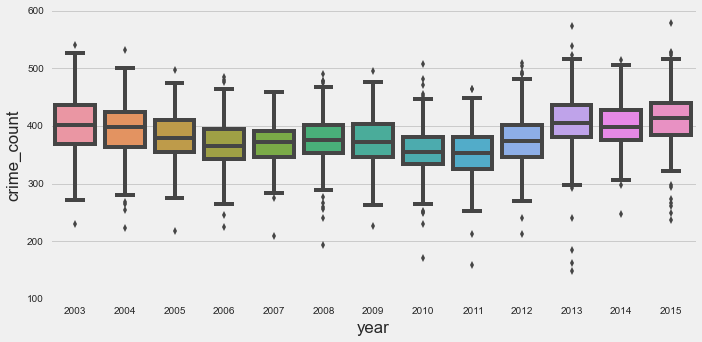

In [9]:
sb.factorplot(data = data, y = 'crime_count', x = 'year', size=5, aspect=2, kind = 'box');

In [10]:
data.sort_values('crime_count', ascending=True).head(30)

,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,dayofweek,day,month,year,...,cloud_cover,events,wind_direction,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
2013-12-25,306,148,39,20,27,2,wednesday,25,12,2013,...,0,No,218,575.833333,0.759167,575.833333,53,63,133.540731,76.470098
2011-12-25,310,159,43,21,25,1,sunday,25,12,2011,...,25,No,206,575.716667,0.020990,431.787500,44,52,97.876907,60.428454
2013-12-24,292,162,18,6,18,0,tuesday,24,12,2013,...,25,No,308,575.633333,0.725214,431.725000,52,59,135.441457,75.218542
2010-12-25,346,171,46,32,32,0,saturday,25,12,2010,...,75,Rain,153,575.766667,0.662599,143.941667,52,56,158.678275,73.390189
2013-12-23,378,184,46,25,47,1,monday,23,12,2013,...,12,No,32,575.483333,0.691261,506.425333,52,60,135.441457,75.918542
2008-12-25,396,193,58,31,43,4,thursday,25,12,2008,...,62,Rain-Thunderstorm,277,575.866667,0.928196,218.829333,49,54,136.502310,59.215718
2007-12-25,394,209,50,26,41,4,tuesday,25,12,2007,...,37,Rain,272,575.683333,0.525707,362.680500,47,54,88.908267,54.475715
2011-11-24,379,212,44,22,39,2,thursday,24,11,2011,...,62,Rain,255,596.216667,0.970036,226.562333,52,56,171.167687,75.626013
2012-12-25,399,213,46,24,39,0,tuesday,25,12,2012,...,87,Rain,217,575.900000,0.407769,74.867000,49,54,144.940989,70.557889
2005-12-25,437,217,50,32,51,3,sunday,25,12,2005,...,100,Rain,136,575.800000,0.804858,0.000000,58,60,270.815564,101.351244


In [11]:
records = data.shape[0]
records

4745

#### Several really low scores 
- After looking at data saw that almost all the low scores where for December 25.
- Reasonable to assume that officers know that Christmas is a special day
- drop data with crime_count less than 250, so Christmas does not skew results

In [12]:
# temp DON'T remove outliers now
#data = data[data['crime_count'] > 275]
data.shape

(4745, 39)

In [13]:
data.sort_values('crime_count', ascending=False).head(15)

,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,dayofweek,day,month,year,...,cloud_cover,events,wind_direction,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
2015-06-28,1182,579,142,87,110,2,sunday,28,6,2015,...,75,No,266,884.200000,0.399978,221.050000,66,72,293.833768,115.471091
2013-11-01,1060,574,107,62,103,5,friday,1,11,2013,...,0,No,315,636.833333,0.926817,636.833333,63,74,201.780692,99.001963
2003-01-01,1078,541,143,91,134,5,wednesday,1,1,2003,...,37,No,86,578.733333,0.950084,364.602000,48,52,160.246207,75.602722
2013-10-04,1005,538,112,58,75,2,friday,4,10,2013,...,0,No,13,700.250000,0.978031,700.250000,69,76,69.000000,95.970016
2004-04-01,958,532,86,37,69,2,thursday,1,4,2004,...,0,No,278,759.033333,0.385993,759.033333,54,64,145.297166,72.152956
2015-05-22,1016,528,101,52,80,1,friday,22,5,2015,...,87,No,265,862.700000,0.142774,112.151000,60,64,238.543985,96.679855
2015-08-28,989,526,124,64,90,8,friday,28,8,2015,...,50,No,293,788.500000,0.463770,394.250000,79,93,391.182226,159.995931
2003-04-11,994,526,87,49,71,5,friday,11,4,2003,...,25,No,203,780.866667,0.322173,585.650000,54,63,176.151075,82.266432
2015-08-07,950,524,73,33,57,2,friday,7,8,2015,...,37,No,232,833.216667,0.754907,524.926500,67,76,286.832737,119.184364
2013-01-01,982,524,129,70,102,3,tuesday,1,1,2013,...,25,No,77,579.133333,0.645382,434.350000,48,53,117.537320,63.702087


#### Several really high scores 
- After looking at data saw that there are just a few days that spiked very high.
- Although I believe that reporting to be true, these few days are probably not related to weather.
- drop data with crime level above 550, to remove these anomalys

In [14]:
# TEMP Block outlier removal
#data = data[data['crime_count'] < 525]
data.shape

(4745, 39)

In [15]:
new_records = data.shape[0]
print records-new_records, ' records removed from original count of ',   records

0  records removed from original count of  4745


### TEMP - Not Removed : Total of 25 records removed out of 4747. 

## Reset the normalization
- When I normalized the crime counts to a 0-10 scale the outliers were still in the data.
- Must reset now that they were removed.

In [16]:
# TEMP Block since did not remove outliers
#high_crime = data['crime_level_sum'].max()
#low_crime = data['crime_level_sum'].min()
#data['crime_level'] = (data['crime_level_sum'] - low_crime) * 10 / (high_crime - low_crime)
#high_w_crime = data['weather_crime_count'].max()
#low_w_crime = data['weather_crime_count'].min()
#data['weather_crime_level'] = (data['weather_crime_count'] - low_w_crime) * 10 / (high_w_crime - low_w_crime)
#data.head()

In [17]:
data[['crime_level', 'weather_crime_level']].describe()

,crime_level,weather_crime_level
count,4745.000000,4745.000000
mean,4.815569,4.281063
std,0.986576,0.991642
min,0.000000,0.000000
25%,4.157303,3.571429
50%,4.786517,4.214286
75%,5.438202,4.857143
max,10.000000,10.000000


## Plot Data
[[back to top](#Sections)]

### Look at distribution of our crime measurement variables
- look at shape of distribution

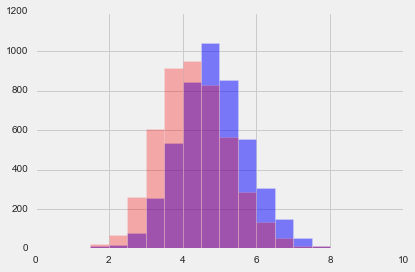

In [18]:
data['crime_level'].hist(bins=20, color='b', alpha=.5);
data['weather_crime_level'].hist(bins=20, color='r', alpha=.3);
plt.tight_layout();

### distribution of the variables that are counts of the number of each type of crime
- 

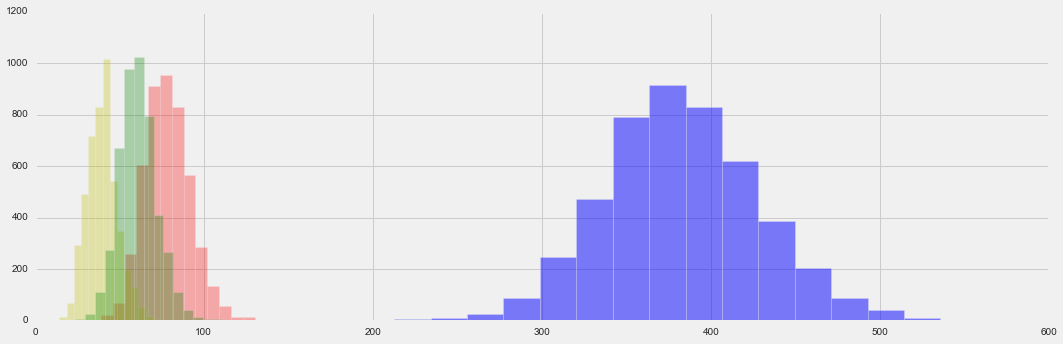

In [19]:
fig = plt.figure(figsize=(15,5))
data['crime_count'].hist(bins=20, color='b', alpha=.5);
data['weather_crime_count'].hist(bins=20, color='r', alpha=.3);
data['violent_count'].hist(bins=20, color='y', alpha=.3);
data['COP_count'].hist(bins=20, color='g', alpha=.3);
plt.tight_layout();

### See what the counts look like over time

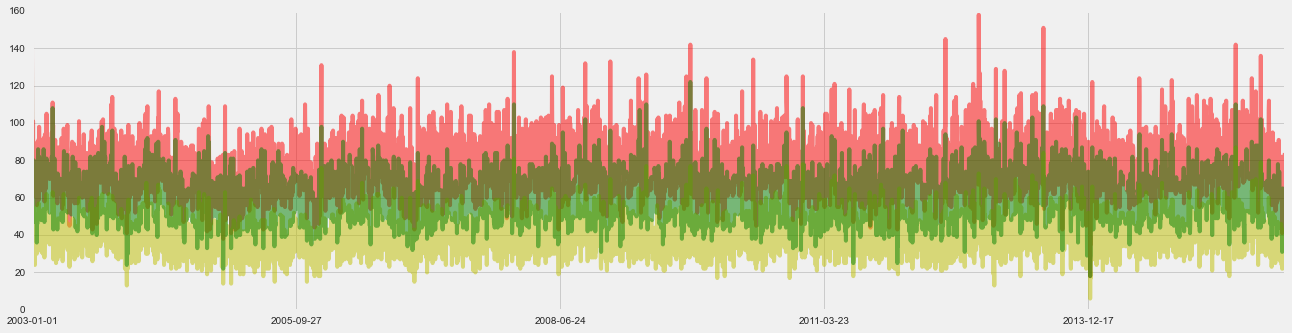

In [20]:
fig = plt.figure(figsize=(20,5))
#data['crime_count'].plot(color='b', alpha=.5)
data['weather_crime_count'].plot(color='r', alpha=.5)
data['violent_count'].plot(color='y', alpha=.5)
data['COP_count'].plot(color='g', alpha=.5)

### Observations

In [21]:
data.corr()

,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,crime_level,weather_crime_level,temp_max,temp_mean,...,precipitation,cloud_cover,wind_direction,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
crime_level_sum,1.000000,0.961699,0.640203,0.595877,0.656848,0.091353,1.000000,0.640203,0.229246,0.235397,...,-0.164085,-0.115482,0.098315,0.073623,0.014431,0.119429,0.235397,0.229246,0.214730,0.241935
crime_count,0.961699,1.000000,0.481714,0.407896,0.522847,0.060706,0.961699,0.481714,0.211590,0.216284,...,-0.174397,-0.117160,0.096385,0.068787,0.011608,0.117983,0.216284,0.211590,0.193121,0.220415
weather_crime_count,0.640203,0.481714,1.000000,0.831454,0.809565,0.243373,0.640203,1.000000,0.193431,0.186668,...,-0.122549,-0.084860,0.109377,0.082025,0.018642,0.094560,0.186668,0.193431,0.120348,0.157983
violent_count,0.595877,0.407896,0.831454,1.000000,0.815069,0.097581,0.595877,0.831454,0.192921,0.180048,...,-0.100932,-0.092309,0.084878,0.058488,0.022846,0.098986,0.180048,0.192921,0.115421,0.156430
COP_count,0.656848,0.522847,0.809565,0.815069,1.000000,0.249189,0.656848,0.809565,0.163744,0.154783,...,-0.118942,-0.084188,0.078680,0.056344,0.025397,0.090054,0.154783,0.163744,0.109848,0.140683
gun_crime_count,0.091353,0.060706,0.243373,0.097581,0.249189,1.000000,0.091353,0.243373,0.026161,0.026184,...,-0.025979,-0.010304,0.025432,0.033103,0.000283,0.019289,0.026184,0.026161,0.004196,0.012674
crime_level,1.000000,0.961699,0.640203,0.595877,0.656848,0.091353,1.000000,0.640203,0.229246,0.235397,...,-0.164085,-0.115482,0.098315,0.073623,0.014431,0.119429,0.235397,0.229246,0.214730,0.241935
weather_crime_level,0.640203,0.481714,1.000000,0.831454,0.809565,0.243373,0.640203,1.000000,0.193431,0.186668,...,-0.122549,-0.084860,0.109377,0.082025,0.018642,0.094560,0.186668,0.193431,0.120348,0.157983
temp_max,0.229246,0.211590,0.193431,0.192921,0.163744,0.026161,0.229246,0.193431,1.000000,0.950802,...,-0.213989,-0.430595,0.433184,0.497940,0.026039,0.540482,0.950802,1.000000,0.696387,0.852066
temp_mean,0.235397,0.216284,0.186668,0.180048,0.154783,0.026184,0.235397,0.186668,0.950802,1.000000,...,-0.165434,-0.248833,0.414428,0.553289,0.024750,0.388143,1.000000,0.950802,0.826268,0.930171


### Look at the variable over temperature

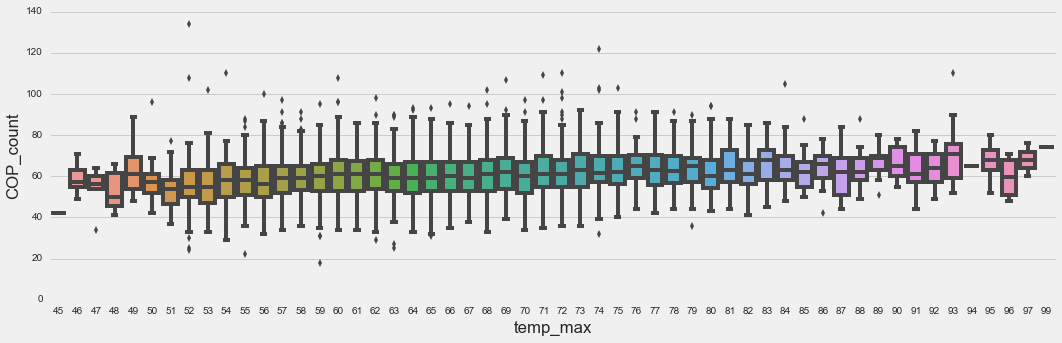

In [22]:
data.sort_values('temp_max', inplace=True)
sb.factorplot(data = data, y = plot_feature, x = 'temp_max', size=5, aspect=3, kind = 'box');

## Look at features with numeric integer values

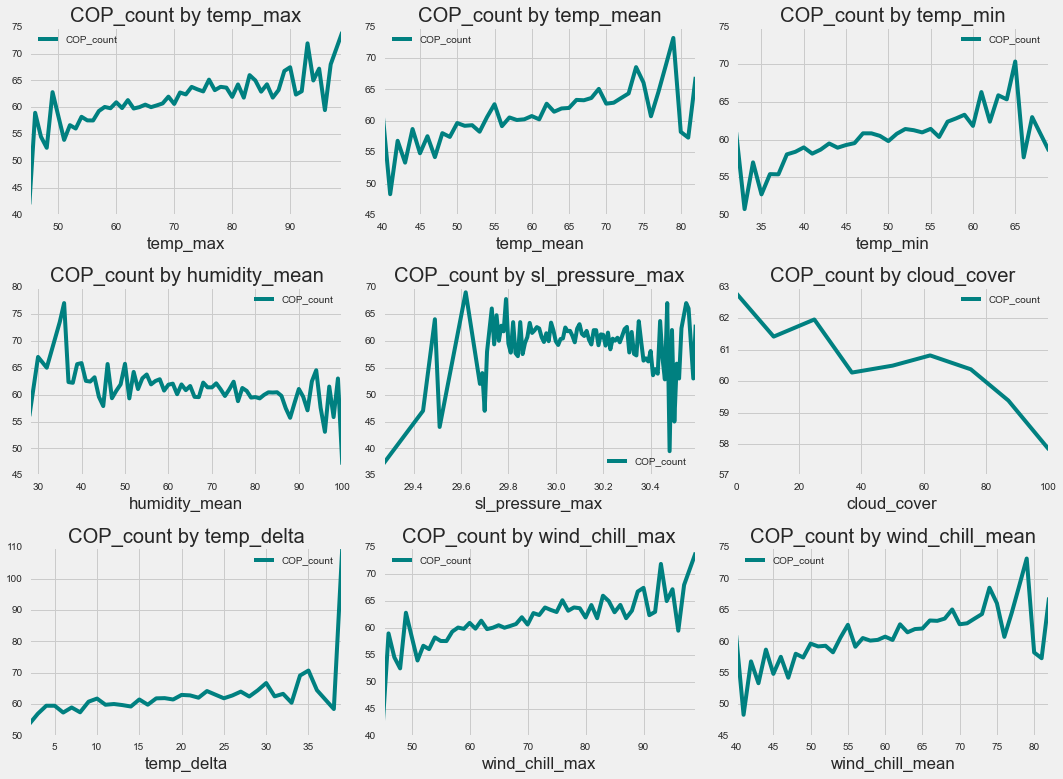

In [23]:
i_features = ['temp_max', 'temp_mean', 'temp_min', 
                 'humidity_mean', 'sl_pressure_max',
                 'cloud_cover', 'temp_delta',
                 'wind_chill_max', 'wind_chill_mean']
fig = plt.figure(figsize=(15,25))
for i, field in enumerate(i_features):
    ax = plt.subplot(7,3,i+1)
    plot_title = plot_feature + ' by ' + str(field)
    group = data.groupby([field])[[plot_feature]].mean()
    group.plot(ax=ax, kind='line', color='teal', title=plot_title)
#    plot_title = 'Test Positive ratio by ' + str(field)
plt.tight_layout();

### Observations
- Several feature seem to plot in a linear fashion. Temperature, Humidity. Much variation at the end points.
- Cloud cover drops off quickly 

## Look at features with numeric real values

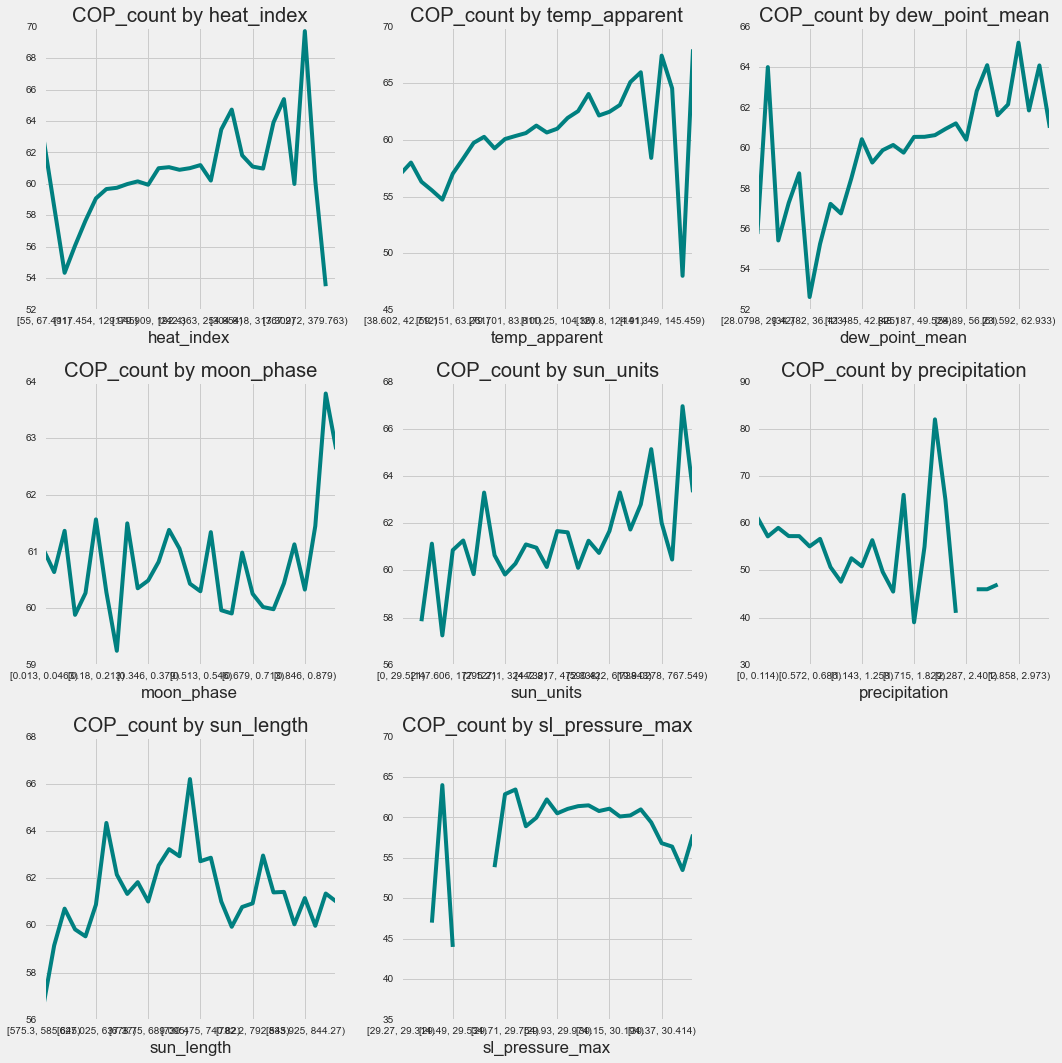

In [24]:
# plot features that need grouping
c_features = ['heat_index', 'temp_apparent', 'dew_point_mean', 'moon_phase', 'sun_units', 
              'precipitation', 'sun_length', 'sl_pressure_max']
fig = plt.figure(figsize=(15,15))
for i, field in enumerate(c_features):
    ax = plt.subplot(3,3,i+1)
    plot_title = plot_feature + ' by ' + str(field)
    high = data[field].max()
    low = data[field].min()
    step = (high-low)/30
    grouped = data.groupby(pd.cut(data[field], np.arange(low, high, step), right=False))
    positive_by_group = grouped.mean()
    positive_by_group[plot_feature].plot.line(ax=ax, color='teal', title= plot_title);
plt.tight_layout();

### Observations
- Temperature and dew points seem to track also.
- Moon phase very random.

## Investigate Categoricals
[[back to top](#Sections)]

## Look at features that are categorical

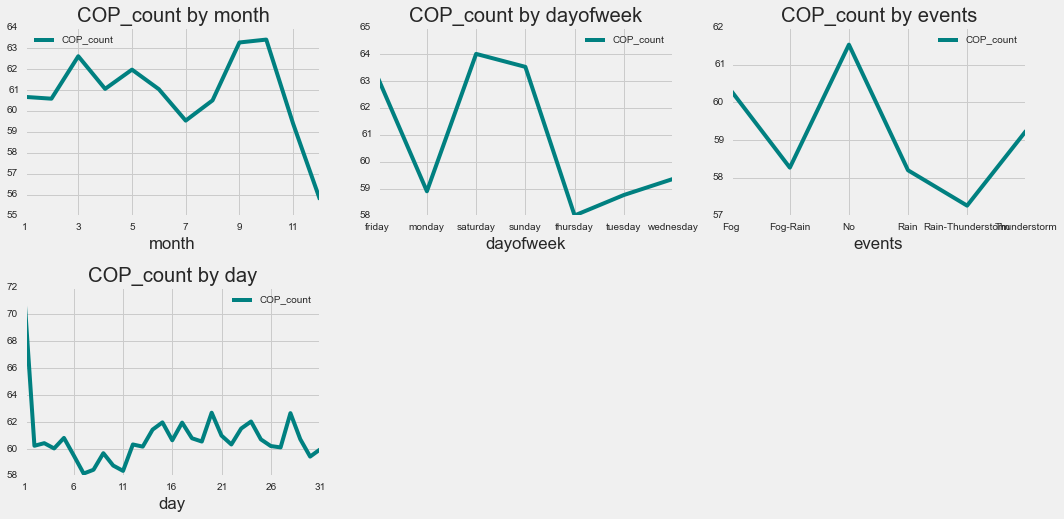

In [25]:
i_features = ['month','dayofweek', 'events','day']
fig = plt.figure(figsize=(15,25))
for i, field in enumerate(i_features):
    ax = plt.subplot(7,3,i+1)
    plot_title = plot_feature + ' by ' + str(field)
    group = data.groupby([field])[[plot_feature]].mean()
    group.plot(ax=ax, kind='line', color='teal', title=plot_title)
#    plot_title = 'Test Positive ratio by ' + str(field)
plt.tight_layout();

In [26]:
data['events'].value_counts()

No                   3520
Rain                  830
Fog                   323
Rain-Thunderstorm      42
Fog-Rain               26
Thunderstorm            4
dtype: int64

### Observations
- Would like to reduce the number of categories these feaetures have. If I don't then they will produce many dummy features if I choose to use them
- Create new features from these categoricals as descibed below

## New Features
[[back to top](#Sections)]

### Add in the 'end_of_week' feature
- Reduce the 7 features for the day of the week to just one that represents the end of the week, Fri, Sat, when the crime level jumps up

In [27]:
list_eow = ['friday', 'saturday']
data.loc[:,'end_of_week'] = data['dayofweek'].apply(lambda x : x in list_eow)
data['end_of_week'].value_counts()


False    3390
True     1355
Name: end_of_week, dtype: int64

### Add in 'winter' feature
- nov, dec had lower crime levels, so add single feature for that.

In [28]:
data.loc[:,'winter'] = data['month'].apply(lambda x : x in [ 11, 12])
data['winter'].value_counts()

False    3953
True      792
Name: winter, dtype: int64

### Add in 'rain' feature - did it rain on the day
- Used to reduce the events category to whether there was rain on the day.
- The forecast does not include Fog or Thunderstorms, so those values will not help
- if 'events' contain Rain

In [29]:
data['events'] = data['events'].astype('object')
data.loc[:,'rain'] = data['events'].str.contains('Rain', case=False)
data['events'] = data['events'].astype('category')

# Summary of Actions
[[back to top](#Sections)]

Observation|Probable Cause|Action|Location
----------|--------|-------|--------
Large number of crimes happened on 1st day of month|Wrong day recorded|Remove from raw data|2_clean_sf_crime
Several outliers in the data|found low days were holiday related|Remove from data|above
Large number of crimes occure on Fri, Sat, Sun|More free time and Partying|Create single 'end_of_week' feature|above
Fewer Crimes during Nov, Dec|Cold Weather and Holidays|Create single 'winter' feature|above
Very few fog and thunderstorm events||Create single 'rain' feature|above

## Write Data to File
[[back to top](#Sections)]

In [30]:
data.to_csv('sf_crime_weather_clean.csv')

# Working Area

In [ ]:
fig = plt.figure(figsize=(15,10))

day_count.plot( kind='line', color='blue')
day_level.plot( kind='line', color='orange')
plt.tight_layout();

In [ ]:
plot_features = ['sun_length', 'sun_units', 'moon_phase']
fig = plt.figure(figsize=(15,15))
for i, field in enumerate(plot_features):
    ax = plt.subplot(4,3,i+1)
#    group = data.groupby([field])[['crime_level']].mean()
    data.plot(ax=ax, x=field, y=plot_feature, kind='scatter', color='teal')
#    plot_title = 'Test Positive ratio by ' + str(field)
plt.tight_layout();

In [ ]:
day_count = data.groupby(['day'])[['crime_count']].mean()
#day_level_sum = data.groupby(['day'])[['crime_level_sum']].mean()
day_level = data.groupby(['day'])[['crime_level']].mean()

fig = plt.figure(figsize=(8,5))
ax = plt.subplot()
ax = day_count.plot(ax=ax, kind='line', color='blue')
day_level.plot(secondary_y=True, ax=ax, kind='line', color='green')
plt.tight_layout();

In [ ]:
sb.factorplot(
    data = data,
    y = plot_feature,
    x = 'year',
    size=5, aspect=3,
    hue = 'events',   # row =   col =  hue =
    #row = 'language',
    kind = 'box'    # 'strip'  'violin' 'box'
);

In [ ]:
sb.factorplot(
    data = data,
    y = plot_feature,
    x = 'year',
    size=5, aspect=3,
    hue = 'end_of_week',   # row =   col =  hue =
    #row = 'language',
    kind = 'box'    # 'strip'  'violin' 'box'
);

In [ ]:
#fig = plt.figure(figsize=(7,5))
#ax = plt.subplot()
#temp_max_level_scale.plot(ax=ax, kind='line', color='blue')
#temp_mean_level_scale.plot(ax=ax, kind='line', color='green')
#temp_min_level_scale.plot(ax=ax, kind='line', color='orange')
#plt.tight_layout();

In [ ]:
#fig = plt.figure(figsize=(15,25))
field = 'temp_mean'
plot_title = plot_feature + ' by ' + str(field)
group = data.groupby([field])[[plot_feature]].mean()
group.plot( kind='line', color='teal', title=plot_title)
#plt.tight_layout();

In [ ]:
mphase_grouped = data.groupby(pd.cut(data['dew_point_mean'], np.arange(0, 1, .02), right=False))
qwert = mphase_grouped.mean()
qwert['crime_level'].plot.line();


In [ ]:
mphase_grouped = data.groupby(pd.cut(data['dew_point_mean'], np.arange(0, 1, .02), right=False))
qwert = mphase_grouped.mean()
qwert['crime_level'].plot.line();




In [ ]:
mphase_grouped = data.groupby(pd.cut(data['moon_phase'], np.arange(0, 1, .02), right=False))
qwert = mphase_grouped.mean()
qwert['weather_crime_level'].plot.line();



In [ ]:
humid_grouped = data.groupby(pd.cut(data['humidity_mean'], np.arange(20, 100, 10), right=False))
qwert = humid_grouped.mean()
qwert['crime_level'].plot.line();

In [ ]:
data[['sun_length', 'crime_level']].sort_values('sun_length', ascending=True).head(20)

In [ ]:
data[data['humidity_mean'] < 30].shape

In [ ]:
data[['humidity_mean', 'crime_level']].sort_values('humidity_mean', ascending=True).head(5)

In [ ]:
sb.pairplot(data[['crime_level','temp_max','end_of_week']], hue='end_of_week')

In [ ]:
sb.pairplot(data[['crime_level','temp_max','winter']], hue='winter')